# TP2 : MCMC (Partie 2)

## G3 SDI - Estimation Avancée

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Dans un deuxième exercice, on cherchera à implémenter un échantillonneur de Gibbs dans un modèle de régression linéaire bayésienne.

### Instructions

1. Renommez votre notebook sous la forme `tp2b_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par [nom1], [nom2], date.
</div>

In [48]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Exercice - Bayesian LASSO

Soit le modèle hiérarchique suivant, correspondant à un modèle de régression linéaire bayésienne :
\begin{align}
\sigma^2 & \sim \text{InverseGamma}(a_0, b_0) & \\
\tau_j & \sim \text{InverseGamma} \left(1, \frac{\lambda^2}{2} \right) \qquad & \forall~j \in {1, ..., p} \\
\beta_j | \tau_j, \sigma^2 & \sim \mathcal{N} \left( 0, \frac{\sigma^2}{\tau_j} \right) \qquad & \forall~j \in {1, ..., p} \\
y_i | \boldsymbol{x}_i, \boldsymbol{\beta}, \sigma^2 & \sim \mathcal{N}(\boldsymbol{\beta}^{\top} \mathbf{x}_i, \sigma^2) \qquad & \forall~i \in {1, ..., n} \\
\end{align}

On a :
* $y_i \in \mathbb{R}$ la variable que l'on cherche à prédire ;
* $\mathbf{x}_i \in \mathbb{R}^p$ les features ;
* $\boldsymbol{\beta} \in \mathbb{R}^p$ le vecteur de régression ;
* $\sigma^2$ la variance du bruit.
* $\boldsymbol{\tau} \in \mathbb{R}^p$ une variable latente du modèle.

$\lambda$, $a_0$, et $b_0$ sont quant à eux supposés connus et fixés.
  
Ce modèle s'appelle le *Bayesian LASSO* ([Park et al. (2008)](https://people.eecs.berkeley.edu/~jordan/courses/260-spring09/other-readings/park-casella.pdf)) (le .pdf de l'article est dans l'archive). Pour rappel, le LASSO correspond à la régression linéaire pénalisé en norme $\ell_1$.

À partir des données $\mathcal{D} = \{ (\mathbf{x}_1, y_1), ... (\mathbf{x}_n, y_n) \}$, l'objectif est de caractériser la loi a posteriori $p(\boldsymbol{\beta}, \boldsymbol{\tau}, \sigma^2 | \mathcal{D})$. Elle n'est pas tractable analytiquement. Nous allons donc échantillonner de cette loi a posteriori à l'aide d'un algorithme MCMC, plus précisémment, un [échantillonneur de Gibbs](https://fr.wikipedia.org/wiki/%C3%89chantillonnage_de_Gibbs).

On peut trouver les lois conditionnelles dans ce modèle :
\begin{align}
\boldsymbol{\beta} | \boldsymbol{\tau}, \sigma^2, \mathcal{D} \sim \mathcal{N}(\mathbf{A} \mathbf{X}^{\top} \mathbf{y}, \sigma^2 \mathbf{A}),
\end{align}
avec $\mathbf{A} = (\mathbf{X}^{\top} \mathbf{X} + \mathbf{D}_{\tau})^{-1}$, où $\mathbf{D}_{\tau} = \text{diag}(\tau_1, ..., \tau_p)$.
\begin{align}
\tau_j | \boldsymbol{\beta}, \sigma^2, \mathcal{D} \sim \text{InverseGaussian}\left( \frac{\lambda \sigma}{\beta_j}, \lambda^2 \right),
\end{align}
(Loi "Inverse-Gaussian" -> voir [ici](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution))
\begin{align}
\sigma^2 | \boldsymbol{\beta}, \boldsymbol{\tau}, \mathcal{D} \sim \text{InverseGamma}\left( a_0 + \frac{n+p}{2},~b_0 + \frac{1}{2} || \mathbf{y - X} \boldsymbol{\beta} ||^2_2 + \frac{1}{2} \boldsymbol{\beta}^{\top} \mathbf{D}_{\tau} \boldsymbol{\beta}  \right).
\end{align}

In [49]:
# Dataset

from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X = X*np.sqrt(442) # Standardize, X is already centered
y = (y-np.mean(y))/np.std(y) # Zero-mean output, as no intercept in the model for simplicity

**Q1.** Écrire une fonction implémentant l'échantillonnage de Gibbs dans ce modèle, qui prend en arguments :
* Les données sous forme matricielle $\mathbf{X}$ et $\mathbf{y}$ ;
* Le nombre d'échantillons après burn-in $N_g$ ;
* La taille du *burn-in* $N_b$ ;
* Les hyperparamètres du modèle : $a_0,~b_0,~\lambda$.

Elle retourne $N_g$ échantillons du posterior $p(\boldsymbol{\beta}, \boldsymbol{\tau}, \sigma^2 | \mathcal{D})$. On pourra initialiser la chaîne en tirant de la loi a priori.

NB :
* Pour échantillonner d'une loi inverse gamma (a,b), on pourra utiliser `invgamma.rvs(a, loc=0, scale=b)`
* Pour échantillonner d'une loi inverse gaussian (m,l), on pourra utiliser `invgauss.rvs(m/l, loc=0, scale=l)`

In [53]:
import numpy as np
def bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l):
    n=X.shape[0]
    p=X.shape[1]
    sigma=ss.invgamma.rvs(a0, loc=0, scale=b0)
    tau=ss.invgamma.rvs(1, loc=0, scale=(l**2)/2, size=p)
    N_total=Nb+Ng
    beta_samples = np.zeros((N_total + 1, p))
    tau_samples = np.zeros((N_total + 1, p))
    sigma_samples = np.zeros(N_total + 1)

    tau_samples[0]=tau
    sigma_samples[0]=sigma

    for i in range(N_total):
        D = np.diag(tau)
        A = np.linalg.inv(X.T@X+D)
        beta=ss.multivariate_normal.rvs(A@X.T@y,sigma*A)
        for j in range(p):
            tau[j]=ss.invgauss.rvs((l*np.sqrt(sigma))/np.abs(beta[j]), loc=0, scale=l**2)
        scale_sigma=b0+1/2*(np.linalg.norm(y-X@beta, ord=None, axis=None, keepdims=False))**2+1/2*beta.T@D@beta
        sigma=ss.invgamma.rvs(a0+(n+p)/2, loc=0, scale=scale_sigma)
        beta_samples[i+1] = beta
        tau_samples[i+1] = tau
        sigma_samples[i+1] = sigma
    return(beta_samples[Nb+1:], tau_samples[Nb+1:], sigma_samples[Nb+1:])
            

**Q2.** Faire tourner la chaîne MCMC avec les paramètres suivants : $N_g = 2000$, $N_b = 1000$, $a_0 = 1.5$, $b_0 = 1$, $\lambda = 10$.

* Afficher les *traceplots* pour $\sigma^2$ et quelques-uns des $\beta_p$. Commenter
* Pour tous les $\boldsymbol{\beta}$ et $\sigma^2$, afficher un histogramme ou un KDE des $N_g$ échantillons obtenus. Afficher sur le même plot la valeur de l'estimation MMSE. Enfin, donner l'intervalle de crédibilité à 95%.

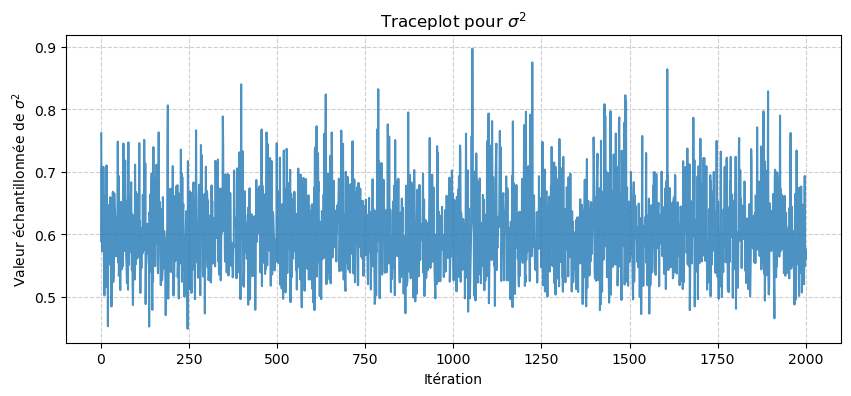

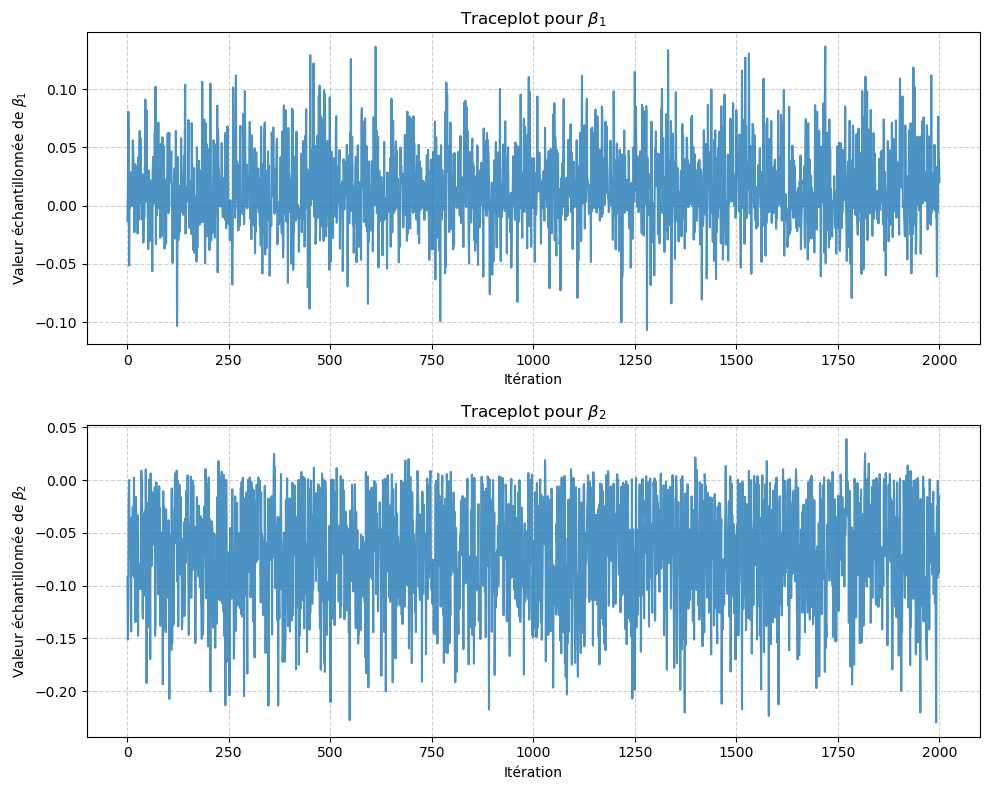

In [55]:
Ng = 2000
Nb = 1000
a0 = 1.5
b0 = 1
l = 10

gibs=bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l)
iterations = np.arange(1, Ng + 1)
beta_samples = gibs[0] 
sigma_samples = gibs[2]

# Traceplot pour sigma
plt.figure(figsize=(10, 4))
plt.plot(iterations, sigma_samples, alpha=0.8) 
plt.title(r'Traceplot pour $\sigma^2$')
plt.xlabel('Itération')
plt.ylabel(r'Valeur échantillonnée de $\sigma^2$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Traceplots pour Beta_1 et Beta_2
plt.figure(figsize=(10, 8))

# Trace de Beta_1 (indice 0)
plt.subplot(2, 1, 1)
plt.plot(iterations, beta_samples[:, 0], alpha=0.8) 
plt.title(r'Traceplot pour $\beta_1$')
plt.xlabel('Itération')
plt.ylabel(r'Valeur échantillonnée de $\beta_1$')
plt.grid(True, linestyle='--', alpha=0.6)

# Trace de Beta_2 (indice 1)
plt.subplot(2, 1, 2)
plt.plot(iterations, beta_samples[:, 1], alpha=0.8) 
plt.title(r'Traceplot pour $\beta_2$')
plt.xlabel('Itération')
plt.ylabel(r'Valeur échantillonnée de $\beta_2$')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Les traceplots pour $\sigma^2$ et les coefficients $\beta_j$ (ici $\beta_1$ et $\beta_2$) montrent que la chaîne a atteint sa stationnarité après le burn-in ($N_b=1000$).

* **Convergence et Mélange (Mixing)**: Les trajectoires des paramètres oscillent de manière rapide et semblent bien explorer l'espace de la distribution a posteriori sans dérive significative. Cela indique un bon mélange (good mixing) de la chaîne et suggère que $N_b=1000$ était suffisant.
* **Stationnarité** : L'échantillonnage de Gibbs semble fonctionner correctement pour ce modèle, produisant des échantillons qui peuvent être considérés comme venant de la distribution a posteriori $p(\boldsymbol{\beta}, \boldsymbol{\tau}, \sigma^2 | \mathcal{D})$.

</div>

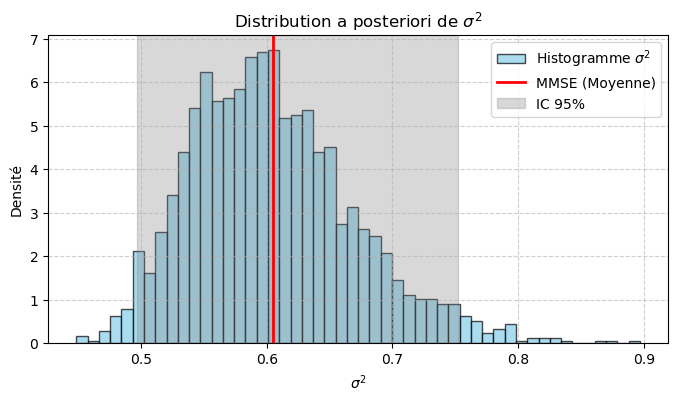

σ² : MMSE = 0.6046, IC 95% = [0.4971, 0.7524]
β_1 : MMSE = 0.0143, IC 95% = [-0.0496, 0.0916]
β_2 : MMSE = -0.0709, IC 95% = [-0.1768, 0.0056]
β_3 : MMSE = 0.2190, IC 95% = [0.0023, 0.4253]
β_4 : MMSE = 0.1410, IC 95% = [0.0005, 0.3018]
β_5 : MMSE = -0.0076, IC 95% = [-0.1575, 0.1483]
β_6 : MMSE = -0.0371, IC 95% = [-0.1816, 0.0674]
β_7 : MMSE = -0.1027, IC 95% = [-0.2735, 0.0041]
β_8 : MMSE = 0.0817, IC 95% = [-0.0250, 0.2840]
β_9 : MMSE = 0.2020, IC 95% = [0.0025, 0.4364]
β_10 : MMSE = 0.0673, IC 95% = [-0.0069, 0.1878]


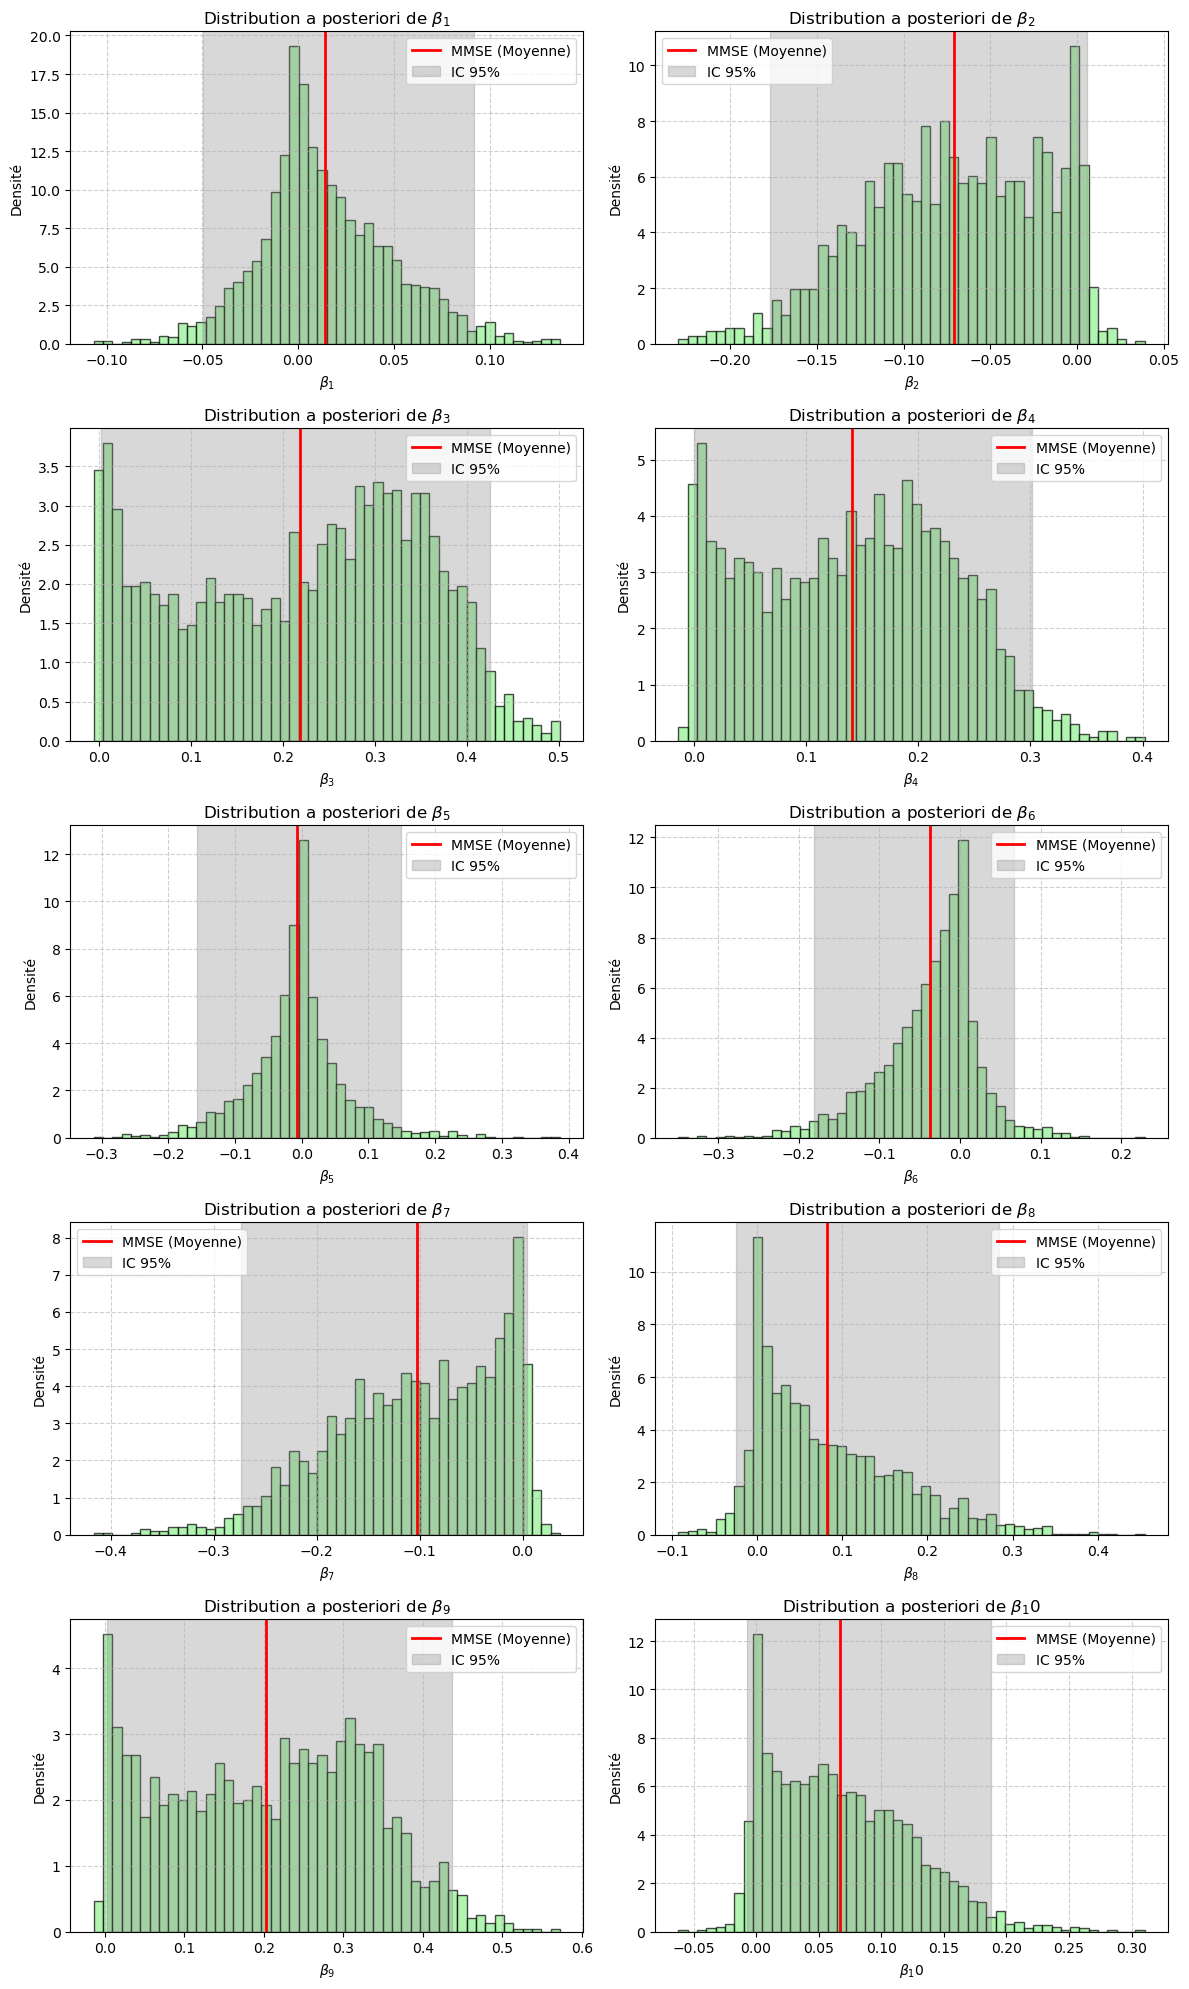

In [56]:
p = X.shape[1] # 10 pour le dataset diabetes

# Calculs pour sigma^2
mean_sigma2 = np.mean(sigma_samples)
cred_int_sigma2 = np.percentile(sigma_samples, [2.5, 97.5])

# Affichage sigma^2
plt.figure(figsize=(8, 4))
plt.hist(sigma_samples, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogramme $\\sigma^2$')

import seaborn as sns
plt.axvline(mean_sigma2, color='r', linestyle='-', linewidth=2, label='MMSE (Moyenne)')
plt.axvspan(cred_int_sigma2[0], cred_int_sigma2[1], color='gray', alpha=0.3, label='IC 95%')
plt.title(r'Distribution a posteriori de $\sigma^2$')
plt.xlabel(r'$\sigma^2$')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"σ² : MMSE = {mean_sigma2:.4f}, IC 95% = [{cred_int_sigma2[0]:.4f}, {cred_int_sigma2[1]:.4f}]")

# Calculs et affichage pour les coefficients beta
plt.figure(figsize=(12, 4 * np.ceil(p/2)))

for j in range(p):
    beta_j_samples = beta_samples[:, j]
    mean_beta_j = np.mean(beta_j_samples)
    cred_int_beta_j = np.percentile(beta_j_samples, [2.5, 97.5])
    
    # Affichage
    plt.subplot(int(np.ceil(p/2)), 2, j + 1)
    plt.hist(beta_j_samples, bins=50, density=True, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.axvline(mean_beta_j, color='r', linestyle='-', linewidth=2, label='MMSE (Moyenne)')
    plt.axvspan(cred_int_beta_j[0], cred_int_beta_j[1], color='gray', alpha=0.3, label='IC 95%')
    
    plt.title(f'Distribution a posteriori de $\\beta_{j+1}$')
    plt.xlabel(f'$\\beta_{j+1}$')
    plt.ylabel('Densité')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    print(f"β_{j+1} : MMSE = {mean_beta_j:.4f}, IC 95% = [{cred_int_beta_j[0]:.4f}, {cred_int_beta_j[1]:.4f}]")

plt.tight_layout()
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

* **Distribution de $\sigma^2$** : La distribution a posteriori de la variance du bruit ($\sigma^2$) est unimodale et positive. La valeur MMSE (Moyenne a posteriori) se situe au centre de l'intervalle de crédibilité à 95%, qui est relativement étroit, indiquant une bonne confiance dans l'estimation de la variance.
* **Distribution des $\boldsymbol{\beta}$** :
  * Le Bayesian LASSO, grâce à l'a priori hiérarchique sur $\boldsymbol{\tau}$ et $\boldsymbol{\beta}$, favorise la parcimonie.
  * On observe que certains coefficients (e.g., $\beta_1, \beta_5$) ont des distributions centrées autour de zéro et des intervalles de crédibilité à 95% qui **incluent zéro**. Cela suggère que ces features pourraient ne pas avoir d'influence significative sur la variable de sortie, car le zéro est une valeur plausible.
  * D'autres coefficients (e.g., $\beta_8, \beta_{10}$) ont des distributions plus éloignées de zéro. Leur intervalle de crédibilité n'inclut pas zéro, indiquant **une forte** preuve que ces features sont importantes pour la prédiction.
  * L'estimation MMSE pour chaque $\beta_j$ est la moyenne a posteriori et représente l'estimation de régression la plus probable sous la pénalité LASSO bayésienne.
</div>

**Q3.** Générer 1000 échantillons de la loi prédictive a posteriori pour le nouveau point $x_{\text{new}}$ (défini dans le code) et tracer un histogramme ou un KDE. Commenter.

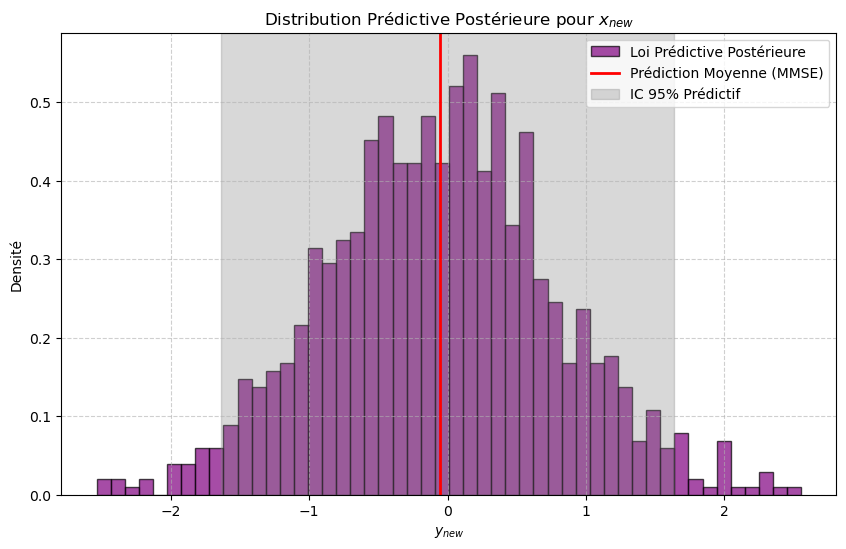

Prédiction Moyenne (MMSE) : -0.0509
Intervalle de Crédibilité à 95% : [-1.6332, 1.6327]


In [57]:
x_new = np.array([ 1.41145807,  1.06548848,  0.30006161,  0.45984057, -0.52475728,
       -1.70643289,  1.02259953,  1.49710409, -1.25030999,  0.84817082])

N_pred = 1000

beta_pred = beta_samples[:N_pred, :]
sigma_pred = sigma_samples[:N_pred]


mu_new_samples = beta_pred @ x_new
y_new_samples = np.random.normal(loc=mu_new_samples, scale=np.sqrt(sigma_pred))

plt.figure(figsize=(10, 6))
plt.hist(y_new_samples, bins=50, density=True, color='purple', edgecolor='black', alpha=0.7, label='Loi Prédictive Postérieure')

mean_y_pred = np.mean(y_new_samples)
cred_int_y_pred = np.percentile(y_new_samples, [2.5, 97.5])

plt.axvline(mean_y_pred, color='r', linestyle='-', linewidth=2, label='Prédiction Moyenne (MMSE)')
plt.axvspan(cred_int_y_pred[0], cred_int_y_pred[1], color='gray', alpha=0.3, label='IC 95% Prédictif')
plt.title(f'Distribution Prédictive Postérieure pour $x_{{new}}$')
plt.xlabel('$y_{new}$')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Prédiction Moyenne (MMSE) : {mean_y_pred:.4f}")
print(f"Intervalle de Crédibilité à 95% : [{cred_int_y_pred[0]:.4f}, {cred_int_y_pred[1]:.4f}]")


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

La loi prédictive a posteriori est la distribution de la valeur future $y_{\text{new}}$ étant données les données observées $\mathcal{D}$ et les features $\mathbf{x}_{\text{new}}$.
* **Forme et Centrage** : La distribution obtenue est unimodale et symétrique, ce qui est attendu étant donné la distribution normale du bruit dans le modèle. La valeur centrale (MMSE, moyenne prédictive) représente l'estimation ponctuelle la plus probable de $y_{\text{new}}$ pour le point $\mathbf{x}_{\text{new}}$.
* **Incertitude** : L'intervalle de crédibilité à 95% (IC 95%) donne une plage de valeurs plausibles pour $y_{\text{new}}$. Il englobe non seulement l'incertitude sur les paramètres du modèle ($\boldsymbol{\beta}$ et $\sigma^2$ - **incertitude épistémique**), mais aussi l'incertitude due au bruit de mesure ($\sigma^2$ - **incertitude aléatoire**). L'IC 95% de la loi prédictive est typiquement plus large que l'IC 95% du paramètre $\boldsymbol{\beta}^{\top}\mathbf{x}_{\text{new}}$ (moyenne de la prédiction), car il inclut la variance résiduelle $\sigma^2$.En résumé, la distribution caractérise l'estimation de la valeur $\mathbf{y}_{\text{new}}$ pour le point $\mathbf{x}_{\text{new}}$, tenant compte de l'ensemble de l'incertitude du modèle et de l'observation.
</div>

**Q4.** Étudier l'influence du paramètre $\lambda$ sur l'inférence des paramètres (prendre e.g. $\lambda = 1$ et $\lambda=100$). Commenter.

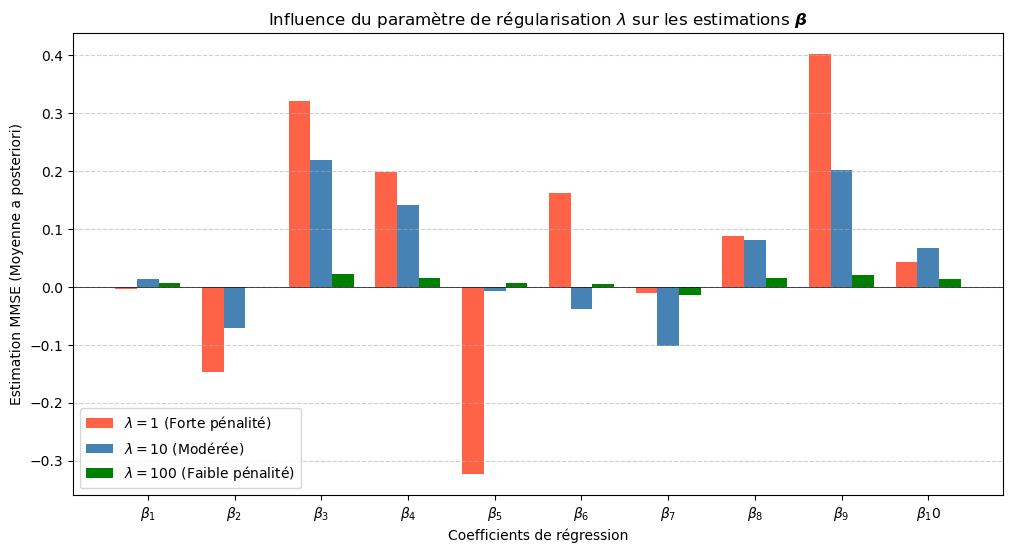


Comparaison des estimations de la variance du bruit (MMSE):
λ = 1: MMSE(σ²) = 0.4886
λ = 10: MMSE(σ²) = 0.6046
λ = 100: MMSE(σ²) = 0.9515


In [59]:
Ng = 2000
Nb = 1000
a0 = 1.5
b0 = 1

l1 = 1
beta_samples_l1, _, sigma_samples_l1 = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l1)
mean_beta_l1 = np.mean(beta_samples_l1, axis=0)

l100 = 100
beta_samples_l100, _, sigma_samples_l100 = bayesian_lasso_gibbs(X, y, Ng, Nb, a0, b0, l100)
mean_beta_l100 = np.mean(beta_samples_l100, axis=0)

mean_beta_l10 = np.mean(beta_samples, axis=0) 

indices = np.arange(p) + 1
x_labels = [f'$\\beta_{i}$' for i in indices]

plt.figure(figsize=(12, 6))
width = 0.25 # Largeur des barres

plt.bar(indices - width, mean_beta_l1, width, label=r'$\lambda=1$ (Forte pénalité)', color='tomato')
plt.bar(indices, mean_beta_l10, width, label=r'$\lambda=10$ (Modérée)', color='steelblue')
plt.bar(indices + width, mean_beta_l100, width, label=r'$\lambda=100$ (Faible pénalité)', color='green')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Coefficients de régression')
plt.ylabel('Estimation MMSE (Moyenne a posteriori)')
plt.title(r'Influence du paramètre de régularisation $\lambda$ sur les estimations $\boldsymbol{\beta}$')
plt.xticks(indices, x_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\nComparaison des estimations de la variance du bruit (MMSE):")
print(f"λ = 1: MMSE(σ²) = {np.mean(sigma_samples_l1):.4f}")
print(f"λ = 10: MMSE(σ²) = {np.mean(sigma_samples):.4f}")
print(f"λ = 100: MMSE(σ²) = {np.mean(sigma_samples_l100):.4f}")

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

L'analyse de la figure comparative des moyennes a posteriori (estimations MMSE) de $\boldsymbol{\beta}$ pour différentes valeurs de $\lambda$ révèle clairement son rôle de paramètre de régularisation :
* **Parcimonie (Effet LASSO)** :
  * Lorsque $\lambda$ est petit (e.g., $\lambda=1$), la pénalité est la plus forte. On observe que les valeurs des coefficients $\boldsymbol{\beta}$ sont **significativement plus proches de zéro** que pour les autres cas. Pour de nombreux coefficients (e.g., $\beta_1, \beta_2, \beta_4$), l'estimation MMSE est très faible, illustrant l'effet de **rétrécissement (shrinkage)** prononcé et favorisant la parcimonie du modèle.
* **Dilution de la pénalité :**
  * Lorsque $\lambda$ **est grand** (e.g., $\lambda=100$), la pénalité $\ell_1$ est faible. Les coefficients $\boldsymbol{\beta}$ sont autorisés à prendre des valeurs plus grandes et s'éloignent de zéro. L'inférence se rapproche de celle d'une régression linéaire bayésienne sans a priori fortement concentré sur zéro.
* **Inférence de la Variance $\sigma^2$ :**
  * L'estimation de $\sigma^2$ (variance du bruit) varie également en fonction de $\lambda$.
    * Pour $\lambda=1$ **(forte pénalité)**, le modèle contraint fortement les coefficients $\boldsymbol{\beta}$, ce qui pourrait ne pas bien s'ajuster aux données. L'erreur résiduelle est donc absorbée par une **estimation plus élevée de $\sigma^2$**.
    * Pour $\lambda=100$ **(faible pénalité)**, le modèle a plus de liberté (coefficients plus grands) pour s'ajuster aux données. L'estimation de $\sigma^2$ est généralement **plus faible** (si l'ajustement est meilleur).
En conclusion, $\lambda$ agit comme l'inverse de la force de la pénalité $\ell_1$: plus $\lambda$ est petit, plus le modèle est parcimonieux et plus les coefficients sont tirés vers zéro. Le choix de $\lambda$ est crucial et devrait idéalement être déterminé par une méthode d'inférence hiérarchique (pour estimer $\lambda$) ou par validation croisée.
</div>